In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry # match country names to iso code
import geoplot as gplt #plotting maps
import geopandas as gpd
import geoplot.crs as gcrs
import imageio #not used ?
import pathlib #not used ?
import matplotlib.pyplot as plt
import mapclassify as mc #???
import os.path
from helpers import * #custom made functions
print("import completed")

# number of pandas rows to display
pd.set_option('display.max_rows', 10)



import completed



 The data for the `Data` folder can be downloaded from [here](https://drive.google.com/drive/folders/1Wz6D2FM25ydFw_-41I9uTwG9uNsN4TCF)

 The initial directory structure for this notebook should be the following:

 ```
 ├── Data/
 │   ├── BeerAdvocate/
 │       ├── beers.csv
 |       ├── breweries.csv
 |       ├── users.csv
 |       ├── reviews.txt
 |       ├── ratings.txt
 │   ├── RateBeer/
 │       ├── beers.csv
 │       ├── breweries.csv
 │       ├── users.csv
 |       ├── reviews.txt
 │       ├── ratings.txt
 │   ├── matched_beer_data/
 │       ├── beers.csv
 |       ├── breweries.csv
 |       ├── ratings.csv
 |       ├── ratings_with_text_ba.txt
 |       ├── ratings_with_text_rb.txt
 |       ├── ratings_ba.txt
 |       ├── ratings_rb.txt
 |       ├── users.csv
 |       ├── users_approx.csv
 ├── README.md
 ├── notebook.ipynb
 ├── requirements.txt
 ├── helpers.py
 └── .gitignore
 ```

In [2]:
#data folder path
data_folder = './Data/'
path_ba = data_folder + 'BeerAdvocate/'
path_rb = data_folder + 'RateBeer/'
path_md = data_folder + 'matched_beer_data/'


 # Table Description

 ### Beers

 Beer Advocate offers a partial column description [here](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/)
 [Here](https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/) is a guide by Beer Advocate on how to review a beer.

 | Column name (RB/BA) | Data type | RB | BA | Description |
 |---|---|---|---|---|
 | beer_id | int | ✓ | ✓ | beer id |
 | beer_name/name | str | ✓ | ✓ | name of the beer |
 | brewery_id | int | ✓ | ✓ | id of the brewery making the beer |
 | brewery_name | str | ✓ | ✓ | name of the brewery making the beer |
 | style | str | ✓ | ✓ | specific sub-category of the beer. On review websites, beers are classified into general categories (lager, belgian ales, etc...) which are broken down into more detailed sub-categories. The list of the styles is not universal and is available on [Rate Beer](https://www.ratebeer.com/beerstyles) and [Beer Advocate](https://www.beeradvocate.com/beer/styles/) website's respectively |
 | nbr_ratings | int | ✓ | ✓ | number of ratings received by the beer |
 | overall_score | int | ✓ | - | score that ranks the beer against all other beers on RateBeer (max=100), uses ratings as well as total number of ratings |
 | style_score | int | ✓ | - | score that ranks the beer against all beers within its own style (max=100), uses ratings as well as total number of ratings |
 | nbr_reviews | int | - | ✓ | on Beer Advocate only, reviews are a subset of ratings which only includes user's review with a score on every category (taste, feel, etc...) as well as a text review|
 | avg | float | ✓ | ✓ | for BA, this is the arithmetic mean (same as avg_computed). However, for RB, it is the average of scores weighted on the amount of reviews. The more reviews a beer gets, the closer the 'avg' gets to the 'avg_computed' (artihmetic mean)|
 | ba_score | int | - | ✓ | BA Score is the beer's overall score based on its ranking within its style category. It's based on the beer's truncated (trimmed) mean and a custom Bayesian (weighted rank) formula that takes the beer's style into consideration. Its purpose is to provide consumers with a quick reference using a format that's familiar to the wine and liquor worlds. <br> 95-100 = world-class <br> 90-94 = outstanding <br> 85-89 = very good <br> 80-84 = good <br> 70-79 = okay <br> 60-69 = poor <br> < 60 = awful |
 | bros_score | float | - | ✓ | Similar to the BA score but only based on the opinion of the website's founders (see [Who are the bros?](https://www.beeradvocate.com/community/threads/the-bros-vs-ba-score.307092/))|
 | abv (alcohol by volume) | float | ✓ | ✓ | Alcohol content By Volume, metric of the percentage of pure ethanol contained in the beer |
 | avg_computed | float | ✓ | ✓ | arithmetic means of ratings |
 | zscore | float | ✓ | ✓ | z-score for the beer ratings |
 | nbr_matched_valid_ratings | int | ✓ | ✓ | number of valid ratings for the beer (from matched dataset)|
 | avg_matched_valid_ratings | int | ✓ | ✓ | average number of valid ratings for the beer (from matched dataset)|


 ### Breweries

 | Column name (RB/BA) | Data type | RB | BA | Description |
 |---|---|---|---|---|
 | id/ brewery_id | int | ✓ | ✓ | brewery id |
 | location | str | ✓ | ✓ | country of brewery (incl. state for the US) |
 | name | str | ✓ | ✓ | name of the brewery |
 | nbr_beers | int | ✓ | ✓ | number of different beers names produced by that brewery |


 ### Users

 | Column name (RB/BA) | Data type | RB | BA | Description |
 |---|---|---|---|---|
 | nbr_ratings | int | ✓ | ✓ | number of ratings a user has given on the website |
 | nbr_reviews | int | ✓ | ✓ | number of reviews a user has given on the website |
 | user_id | int | ✓ | ✓ | user id |
 | user_name | str | ✓ | ✓ | user name |
 | joined | int | ✓ | ✓ | UNIX time stamp for user account creation |
 | location | str | ✓ | ✓ | country of origin of the user (incl. state for the US) |


 ### Ratings

 The difference in columns between reviews and ratings is only the boolean flag `reviews` for the BA dataset.
 For RB there is no difference between reviews and ratings.

 | Column name (RB/BA) | Data type (RB/BA) | RB | BA | Description |
 |---|---|---|---|---|
 | beer_name | str | ✓ | ✓ | name of the beer |
 | beer_id | int | ✓ | ✓ | id of the beer |
 | brewery_name | str | ✓ | ✓ | name of the brewery which the beer belongs to |
 | brewery_id | int | ✓ | ✓ | id of the brewery the beer belongs to |
 | style | str | ✓ | ✓ | classification of the type of beer (website dependent) |
 | abv | float | ✓ | ✓ | alcohol content by volume |
 | date | int | ✓ | ✓ | UNIX time stamp for user account creation |
 | user_name | str | ✓ | ✓ | name of the user giving the rating |
 | user_id | int | ✓ | ✓ | id of the user giving the rating |
 | appearance | int/float | ✓ | ✓ | rating for the appearance of the beer |
 | aroma | int/float | ✓ | ✓ | rating for the aroma of the beer |
 | palate | int/float | ✓ | ✓ | rating for the palate of the beer |
 | taste | int/float | ✓ | ✓ | rating for the taste of the beer |
 | overall | int/float | ✓ | - | score that ranks the beer against all other beers on RateBeer (max=100), uses ratings as well as total number of ratings - explained [here](https://www.ratebeer.com/our-scores#:~:text=Aroma%20and%20Taste%20are%20scored,of%205%20for%20each%20rating) |
 | rating | float | ✓ | ✓ | this is the weighted average rating for the beer e.g see details for BA [here](https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/) |
 | text | str | ✓ | ✓ | text of the rating |
 | review | bool | ✓ | - | true if the rating is a review |


 # Pipeline
 ## Subsetting to the matched beer/brewery data
 We conduct our analyses separately for both the BeerAdvocate and RateBeer datasets in order to be able to compare our results
 and check if they are robust between the two datasets. The goal of this is to try and remove an extra source of variation
 due to the different user bases on the two websites.

 Based on the merged dataset, we subset to beers and breweries that are presents in both datasets, provided in `matched_beer_data/beers.csv` and `matched_beer_data/breweries.csv`.
 We also conduct some preliminary cleaning and analysis of this matched dataset.

 Column dropping justification:
 - `ba_score`: only available in BA dataset (internal BA metric for overall ranking)
 - `bros_score`: only available in BA dataset (internal BA metric)
 - `nbr_ratings`: need to be recomputed at a later stage since we are subseting ratings
 - `nbr_reviews`: same argument as in `nbr_ratings`
 - `overall_score`: only available in RB dataset (internal RB metric for overall ranking)
 - `style_score`: only avaiable in RB dataset (internal RB metric for style ranking)
 - `avg_matched_...` : not necessary for our analysis

 We also drop beers (rows) that don't have at least 1 review on each website (NaN avg score in either RB or BA dataset)


 ### Load and filter merged beer/brewery data
 #### Loading Beer Dataset (merged)

In [3]:
#loading and naming columns
df_beers = pd.read_csv(path_md + "beers.csv", header=1)
#dropping features that only exist in 1 dataset
df_beers = df_beers.drop(["ba_score", "bros_score", "nbr_reviews", "nbr_ratings", "nbr_ratings.1", "overall_score", "style_score", "avg_matched_valid_ratings", "nbr_matched_valid_ratings", "avg_matched_valid_ratings.1", "nbr_matched_valid_ratings.1", "zscore", "zscore.1"], axis=1)

df_beers = df_beers.rename(columns={key: f"{key}_ba" for key in df_beers.columns[0:9]}) #rename columns to highlight dataset of origin
df_beers = df_beers.rename(columns={key: f"{key[:-2]}_rb" for key in df_beers.columns[9:18]})

#nan checks:
print("--- Initial number of NaN Values: ---")
print(df_beers.isna().sum())
#NaN values in avg means a beer from one website doesn't have any review on the other website. => we only keep beers with at least 1 review on both website (drop NaNs)
df_beers = df_beers.loc[df_beers[["avg_ba","avg_computed_ba", "avg_rb", "avg_computed_rb"]].isna().sum(axis=1) == 0]
print(f"number of beers in matched dataset after cleaning {len(df_beers)}")
print("--- Number of NaN Values after Processing: ---")
print(df_beers.isna().sum())
#no NAN lefts !
print("--- Print Info ---")
print(df_beers.info())


--- Initial number of NaN Values: ---
abv_ba                0
avg_ba             5355
avg_computed_ba    5355
beer_id_ba            0
beer_name_ba          0
                   ... 
brewery_id_rb         0
brewery_name_rb       0
style_rb              0
diff                  0
sim                   0
Length: 20, dtype: int64
number of beers in matched dataset after cleaning 38022
--- Number of NaN Values after Processing: ---
abv_ba             0
avg_ba             0
avg_computed_ba    0
beer_id_ba         0
beer_name_ba       0
                  ..
brewery_id_rb      0
brewery_name_rb    0
style_rb           0
diff               0
sim                0
Length: 20, dtype: int64
--- Print Info ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38022 entries, 0 to 45639
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   abv_ba                     38022 non-null  float64
 1   avg_ba       

 How many beer did we drop with respect to the Beer Advocate dataset?

In [4]:
df_ba_beers = pd.read_csv(path_ba + 'beers.csv')
df_rb_beers = pd.read_csv(path_rb + 'beers.csv')

print(f"number of beers in BeerAdvocate dataset {len(df_ba_beers)}")
print(f"number of beers in RateBeer dataset {len(df_rb_beers)}")
print(f"number of beers in matched dataset {len(df_beers)}")

number of beers in BeerAdvocate dataset 280823
number of beers in RateBeer dataset 442081
number of beers in matched dataset 38022


 With respect to BA, we lost about 87% of the beers.
 With respect to RB, we lost about 92% of the beers.
 38k is still a significant number and this quantity suffices for our analysis

 Sanity checks
 Are the abv contents the same in both datasets?

In [5]:
print(df_beers.loc[df_beers["abv_ba"] != df_beers["abv_rb"]])

Empty DataFrame
Columns: [abv_ba, avg_ba, avg_computed_ba, beer_id_ba, beer_name_ba, beer_wout_brewery_name_ba, brewery_id_ba, brewery_name_ba, style_ba, abv_rb, avg_rb, avg_computed_rb, beer_id_rb, beer_name_rb, beer_wout_brewery_name_rb, brewery_id_rb, brewery_name_rb, style_rb, diff, sim]
Index: []


 Do the names match ? Most of them don't. BA don't include the brewery name in the beer name but RB often does. We will keep the RB names since they are more informative.

In [6]:
df_beers.loc[df_beers["beer_name_ba"] != df_beers["beer_name_rb"]].head()


,abv_ba,avg_ba,avg_computed_ba,beer_id_ba,beer_name_ba,beer_wout_brewery_name_ba,brewery_id_ba,brewery_name_ba,style_ba,abv_rb,avg_rb,avg_computed_rb,beer_id_rb,beer_name_rb,beer_wout_brewery_name_rb,brewery_id_rb,brewery_name_rb,style_rb,diff,sim
0,4.8,3.45,3.439867,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4.8,2.79,2.923596,37923,Strangford Lough Legbiter,Legbiter,4959,Strangford Lough,Golden Ale/Blond Ale,1.000000,1.0
1,6.0,3.86,3.888750,20841,St. Patrick's Ale,Patricks Ale St,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,6.0,3.10,3.290909,41286,Strangford Lough St. Patricks Ale,Patricks Ale St,4959,Strangford Lough,Irish Ale,0.527141,1.0
2,4.2,3.56,3.556094,20842,St. Patrick's Best,Patricks Best St,10093,Strangford Lough Brewing Company Ltd,English Bitter,4.2,2.82,2.831081,41287,Strangford Lough St. Patricks Best,Patricks Best St,4959,Strangford Lough,Bitter,0.527141,1.0
3,4.8,3.96,3.960000,22659,St. Patrick's Gold,Patricks Gold St,10093,Strangford Lough Brewing Company Ltd,American Pale Wheat Ale,4.8,2.76,2.775000,41285,Strangford Lough St. Patricks Gold,Patricks Gold St,4959,Strangford Lough,Amber Ale,0.527141,1.0
5,4.2,3.95,3.950000,178689,Boom,Boom,40360,Walled City Brewing Company,American Pale Ale (APA),4.2,3.16,3.600000,368966,Walled City Boom,Boom,24866,Walled City,American Pale Ale,1.000000,1.0


 ### Breweries

In [7]:
#loading and renaming columns
df_brew = pd.read_csv(path_md + "breweries.csv", header = 1)
df_brew = df_brew.rename(columns={key: f"{key}_ba" for key in df_brew.columns[0:4]}) #rename columns to highlight dataset of origine
df_brew = df_brew.rename(columns={key: f"{key[:-2]}_rb" for key in df_brew.columns[4:8]})

#updating breweries list and beer count according to the beer we removed in the previous section
nb_beers_ba = df_beers.groupby("brewery_id_ba").size()
nb_beers_rb = df_beers.groupby("brewery_id_rb").size()

def map_element(element, df):
    """
    try to find an element in a dataframe, returns 0 if not found.
    """
    try:
        return df.loc[element]
    except:
        return 0

# create new columns for later use
df_brew["nbr_beers_ba"] = df_brew.apply(lambda x: map_element(x["id_ba"], nb_beers_ba), axis=1)
df_brew["nbr_beers_rb"] = df_brew.apply(lambda x: map_element(x["id_rb"], nb_beers_rb), axis=1)
df_brew = df_brew.loc[df_brew["nbr_beers_ba"] > 0] #subset
df_brew = df_brew.loc[df_brew["nbr_beers_rb"] > 0] #subset
print(f"number of beers in the beers dataframe {len(df_beers)}")
nb = df_brew["nbr_beers_ba"].sum() #find count
print(f"number of beers in the brewery dataframe {nb}")
#do number of beers per brewery matches between the two datasets ?
non_matching_brew = df_brew.loc[df_brew["nbr_beers_ba"] != df_brew["nbr_beers_rb"]] # find when not matching
non_matching_brew.head()

number of beers in the beers dataframe 38022
number of beers in the brewery dataframe 38022


,id_ba,location_ba,name_ba,nbr_beers_ba,id_rb,location_rb,name_rb,nbr_beers_rb,diff,sim
3475,5368,Sweden,Carlsberg Sverige,1,765,Sweden,Carlsberg Sverige,20,0.495181,1.000000
3476,10897,Sweden,Carlsberg Sverige AB,19,765,Sweden,Carlsberg Sverige,20,0.425746,0.859779
4175,12402,"United States, California",SLO Brewing Co.,6,414,"United States, California",SLO Brew,7,0.386060,0.815074
4176,255,"United States, California",SLO Brewing Company,1,414,"United States, California",SLO Brew,7,0.506316,0.848019
4215,6067,"United States, California",BrewBakers,1,390,"United States, California",Brewbakers Brewing Company,3,0.321064,0.935298


In [8]:
#In most cases yes. In BA, some breweries appear twice, either because there are duplicate (Brewery company, Brewery co.) or because some brewery have two distinct physical location (eg. Brewery North, Brewery South).
#This problem only occurs for tiny minority of beers and brewery. We then simply drop them and as well as the corresponding beers from those breweries.
df_brew = df_brew.loc[df_brew["nbr_beers_ba"] == df_brew["nbr_beers_rb"]]
df_beers = df_beers.loc[~df_beers["brewery_id_ba"].isin(non_matching_brew["id_ba"])] # subset to when in both


 ###### Location processing
 countries sometimes have several names, the official name ("United States of America") and common names ("US, united states, the states, etc..."). In order to plot location on a map, we decide to replace all location names with ISO 3166-1 alpha-3 (3 letter country abbreviation). This is done using the ["search_fuzzy"](https://pypi.org/project/pycountry/) function in the pycountry library. The state column is only valid for breweries (and at a later stage users) within the united states, for which we have state-wide granularity

In [9]:
def location_processing(location):
    print(location)
    # removing html tags
    location = location.apply(lambda x : x.split('<', 1)[0])
    # separating country from states (for USA)
    country = location.apply(lambda x : x.split(',', 1)[0])
    states = location.apply(lambda x : str(x.split(',', 1)[1])[1:] if ',' in x else np.nan)

    #get the list of country and match it to an iso code utilizing the find_iso function
    country_list = country.unique()
    country_iso = {x: find_iso(x) for x in country_list}
    country_code = country.apply(lambda x: country_iso[x])

    return country, states, country_code


In [10]:
# location processing for breweries
country, states, country_code = location_processing(df_brew['location_ba'])
df_brew['country']=country
df_brew['states']=states
df_brew['country_code']=country_code
print("No country code assignment to the following countries: ", df_brew[df_brew["country_code"].isnull()]["country"].value_counts())


0                   Northern Ireland
2                   Northern Ireland
3                   Northern Ireland
5                   Northern Ireland
7                   Northern Ireland
                    ...             
8262      United States, Connecticut
8263        United States, Minnesota
8267          United States, Florida
8270    United States, Massachusetts
8276          United States, Indiana
Name: location_ba, Length: 5488, dtype: object
No country code assignment to the following countries:  South Korea              6
Laos                     2
Trinidad & Tobago        1
Ivory Coast              1
Cape Verde Islands       1
North Korea              1
Virgin Islands (U.S.)    1
Name: country, dtype: int64


In [11]:
# assign a location by looking up the location of each beers' brewery

df_beers = df_beers.merge(df_brew[["country", "states", "country_code", "id_ba"]], left_on="brewery_id_ba", right_on="id_ba")
# country = df_beers.apply(lambda beer: df_brew.loc[df_brew['name_ba'] == beer['brewery_name_ba']]['country'], axis = 1)
# print(country)


 ### Filtering and Transforming - Create dataframes for later use

 In this previous section, we created matched beer and breweries. However, we need access to users and ratings in order to conduct our analysis.

 For both datasets, we take the ratings and not the reviews. This is to maximise the amount of textual data we can obtain since reviews is a subset of reviews.

 To this end, we conduct an analysis to find all the users and ratings related to the subsetted beers for the previous section.
 We do this in a number of steps
 1. We preprocess by dropping rows where we find NaN values for both users and ratings. We add a location and a country column for the users.
 2. We subset to consider only ratings on the matched beers.
 3. We subset users to only the users who wrote the reviews we just found in step 2.
 4. We save all of these new datasets to pickles.

 #### Beer Advocate Ratings
 ##### Load BA User Data

In [12]:
df_ba_users = pd.read_csv(path_ba + "users.csv")
# We do not know 1 username, 2652 join dates and 31279 locations (i.e. they are nan)
# Since we are doing some geographical analysis, locations are mandatory and we drop users without location infos
df_ba_users = df_ba_users.dropna()


 ### location processing for ba users

In [13]:
country, states, country_code = location_processing(df_ba_users['location'])
df_ba_users['country'] = country
df_ba_users['states'] = states
df_ba_users['country_code'] = country_code
print("No country code assignment to the following countries: ", df_ba_users[df_ba_users["country_code"].isnull()]["country"].value_counts())
#there are only 5 regions which don't find a matching iso-code, which corresponds to 54 users.

# manually add New Zealand and Australia, and then remove the other outliers (not worth considering)
df_ba_users['country_code'] = np.where(df_ba_users['location']=="Aotearoa", "NZL", df_ba_users['country_code'])
df_ba_users['country_code'] = np.where(df_ba_users['location']=="Heard and McDonald Islands", "AUS", df_ba_users['country_code'])
df_ba_users = df_ba_users[~df_ba_users['country_code'].isna()]



0         United States, Washington
1           United States, New York
2                  Northern Ireland
3                  Northern Ireland
4                  Northern Ireland
                    ...            
153698    United States, California
153699    United States, California
153700    United States, California
153702    United States, California
153703    United States, California
Name: location, Length: 122424, dtype: object
No country code assignment to the following countries:  Aotearoa                                    49
Svalbard and Jan Mayen Islands               2
Fiji Islands                                 1
Heard and McDonald Islands                   1
South Georgia and South Sandwich Islands     1
Name: country, dtype: int64


 We the UK as one region as opposed to its sub-countries England, Wales, Scotland and Northern Ireland since there are not a lot users in the separate regions

In [14]:
print(df_ba_users[df_ba_users['country_code']=='GBR']['location'].value_counts())


England             791
Scotland            100
Wales                32
Northern Ireland     22
Name: location, dtype: int64


In [15]:
df_ba_users.head()


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,country,states,country_code
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington",United States,Washington,USA
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York",United States,New York,USA
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland,Northern Ireland,NaN,GBR
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland,Northern Ireland,NaN,GBR
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland,Northern Ireland,NaN,GBR


In [16]:
df_ba_users.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 122420 entries, 0 to 153703
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   nbr_ratings   122420 non-null  int64  
 1   nbr_reviews   122420 non-null  int64  
 2   user_id       122420 non-null  object 
 3   user_name     122420 non-null  object 
 4   joined        122420 non-null  float64
 5   location      122420 non-null  object 
 6   country       122420 non-null  object 
 7   states        113222 non-null  object 
 8   country_code  122420 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 9.3+ MB


 ##### Load BA Ratings
 We consider only the ratings for Beer Advocate as the reviews are a subset of the ratings. We then filter out all NaN values in the ratings.

In [17]:
df_ba_ratings = pickle_load(path_ba + "ratings.txt",load_with_text=True)
df_ba_ratings.set_index(df_ba_ratings["date"], inplace = True) # Set date as index for ratings
df_ba_ratings = df_ba_ratings.convert_dtypes(infer_objects=True) # infer correct string types (does not filter nan values)
df_ba_ratings[["overall","taste","palate","aroma","appearance","abv"]] = df_ba_ratings[["overall","taste","palate","aroma","appearance","abv"]].apply(lambda x : pd.to_numeric(x,errors="coerce")) # coerce to numeric
df_ba_ratings = df_ba_ratings.astype({"review":bool}) # convert to boolean
df_ba_ratings["text"] = df_ba_ratings["text"].apply(lambda x: x if str.lower(x) != "nan" else "") # convert nan to empty string
df_ba_ratings = df_ba_ratings.dropna() # drop nan values
df_ba_ratings.info() # print info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4654808 entries, 2015-08-20 10:00:00 to 2006-02-19 11:00:00
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   beer_name     string        
 1   beer_id       string        
 2   brewery_name  string        
 3   brewery_id    string        
 4   style         string        
 5   abv           float64       
 6   date          datetime64[ns]
 7   user_name     string        
 8   user_id       string        
 9   appearance    float64       
 10  aroma         float64       
 11  palate        float64       
 12  taste         float64       
 13  overall       float64       
 14  rating        Float64       
 15  text          object        
 16  review        bool          
dtypes: Float64(1), bool(1), datetime64[ns](1), float64(6), object(1), string(7)
memory usage: 612.6+ MB


In [18]:
df_ba_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
date,,,,,,,,,,,,,,,,,
2015-08-20 10:00:00,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True
2009-02-20 11:00:00,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True
2006-03-13 11:00:00,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True
2004-12-01 11:00:00,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wit...,True
2004-08-30 10:00:00,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.0,"500ml bottlePours with a light, slightly hazy ...",True


In [19]:
print("Number of nan values",df_ba_ratings.isna().sum())
print("Number of non-reviews:",df_ba_ratings[df_ba_ratings["review"] == False].shape[0])
print("Number of text that is 'nan':",df_ba_ratings[df_ba_ratings["text"].str.lower() == "nan"].shape[0])
for column in ["beer_name","beer_id","brewery_name","brewery_name","style","user_name","user_id"]:
        print(f"number of values in {column} that is 'nan'", df_ba_ratings[df_ba_ratings[column].str.lower() == "nan"].shape[0])


Number of nan values beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
               ..
taste           0
overall         0
rating          0
text            0
review          0
Length: 17, dtype: int64
Number of non-reviews: 0
Number of text that is 'nan': 0
number of values in beer_name that is 'nan' 0
number of values in beer_id that is 'nan' 0
number of values in brewery_name that is 'nan' 0
number of values in brewery_name that is 'nan' 0
number of values in style that is 'nan' 0
number of values in user_name that is 'nan' 0
number of values in user_id that is 'nan' 0


 ##### Merge BA Ratings and Users for beers from the matched Dataset
 Filter BA Ratings to only keep beers in matched beer dataset

In [20]:
df_md_beer_ids = df_beers["beer_id_ba"].unique().astype(str)
df_ba_beer_ids = df_ba_ratings["beer_id"].unique()
df_ba_ratings_filtered_md_beers = df_ba_ratings[df_ba_ratings["beer_id"].isin(df_md_beer_ids)]
df_ba_ratings_filtered_beers_merged_users = df_ba_ratings_filtered_md_beers.merge(df_ba_users, left_on="user_id", right_on="user_id")
df_ba_ratings_filtered_beers_merged_users.isnull().sum()

beer_name           0
beer_id             0
brewery_name        0
brewery_id          0
style               0
                ...  
joined              0
location            0
country             0
states          58171
country_code        0
Length: 25, dtype: int64

In [21]:
ba_pickle_filename = "df_ba_ratings_filtered_beers_merged_users.pickle"

In [22]:
df_ba_ratings_filtered_beers_merged_users.to_pickle(f"Data/{ba_pickle_filename}")

In [23]:

df_ba_ratings_filtered_beers_merged_users = pd.read_pickle(f"Data/{ba_pickle_filename}")
df_ba_ratings_filtered_beers_merged_users.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name_x,user_id,appearance,...,text,review,nbr_ratings,nbr_reviews,user_name_y,joined,location,country,states,country_code
0,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2013-02-13 11:00:00,brewdude1982,brewdude1982.691169,4.25,...,This was a 12 oz bottle poured into a snifter....,True,264,95,brewdude1982,1.345802e+09,"United States, North Carolina",United States,North Carolina,USA
1,Onyx Black Ale,56551,Stevens Point Brewery,786,American Brown Ale,5.2,2012-12-07 11:00:00,brewdude1982,brewdude1982.691169,4.50,...,This was a 12 oz can poured into a snifter.It ...,True,264,95,brewdude1982,1.345802e+09,"United States, North Carolina",United States,North Carolina,USA
2,Winter Ale,1591,Weyerbacher Brewing Co.,392,English Brown Ale,5.6,2012-12-07 11:00:00,brewdude1982,brewdude1982.691169,4.00,...,This wasa 12 oz bottle poured into a snifter.P...,True,264,95,brewdude1982,1.345802e+09,"United States, North Carolina",United States,North Carolina,USA
3,Chombers One,85209,Fullsteam Brewery,23145,Belgian Pale Ale,6.7,2013-01-12 11:00:00,brewdude1982,brewdude1982.691169,4.50,...,This was a bomber poured into a snifter.It pou...,True,264,95,brewdude1982,1.345802e+09,"United States, North Carolina",United States,North Carolina,USA
4,The Beer With No Name,89143,Lonerider Brewing Company,19126,Dubbel,8.0,2013-01-23 11:00:00,brewdude1982,brewdude1982.691169,4.50,...,A: 4.5 dark brown with great clarity and tiny ...,True,264,95,brewdude1982,1.345802e+09,"United States, North Carolina",United States,North Carolina,USA


In [24]:
df_ba_ratings_filtered_beers_merged_users.info()
df_ba = df_ba_ratings_filtered_beers_merged_users


<class 'pandas.core.frame.DataFrame'>
Int64Index: 562762 entries, 0 to 562761
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   beer_name     562762 non-null  string        
 1   beer_id       562762 non-null  string        
 2   brewery_name  562762 non-null  string        
 3   brewery_id    562762 non-null  string        
 4   style         562762 non-null  string        
 5   abv           562762 non-null  float64       
 6   date          562762 non-null  datetime64[ns]
 7   user_name_x   562762 non-null  string        
 8   user_id       562762 non-null  object        
 9   appearance    562762 non-null  float64       
 10  aroma         562762 non-null  float64       
 11  palate        562762 non-null  float64       
 12  taste         562762 non-null  float64       
 13  overall       562762 non-null  float64       
 14  rating        562762 non-null  Float64       
 15  text          562

 #### RateBeer Ratings
 ##### Load RB User Data

In [25]:
df_rb_users = pd.read_csv(path_rb + 'users.csv')
df_rb_users = df_rb_users.convert_dtypes(infer_objects=True) 
df_rb_users.head()


,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1337508000,Poland
1,89,442761,MAGICuenca91,1484046000,Spain
2,169,288889,Sibarh,1384599600,Poland
3,3371,250510,fombe89,1363950000,Spain
4,13043,122778,kevnic2008,1296644400,Germany


In [26]:
df_rb_users.isna().sum()


nbr_ratings        0
user_id            0
user_name          0
joined            30
location       19582
dtype: int64

In [27]:
# remove lines with nan
df_rb_users = df_rb_users.dropna()

country, states, country_code = location_processing(df_rb_users['location'])
df_rb_users['country'] = country
df_rb_users['states'] = states
df_rb_users['country_code'] = country_code
print("No country code assignment to the following countries: ", df_rb_users[df_rb_users["country_code"].isnull()]["country"].value_counts())
# We keep the most import regions but remove the others. We only consider US states so we drop the US Virgin Islands.
df_rb_users['country_code'] = np.where(df_rb_users['country']=="Virgin Islands (British)", "GBR", df_rb_users['country_code'])
df_rb_users['country_code'] = np.where(df_rb_users['country']=="South Korea", "ROK", df_rb_users['country_code'])
df_rb_users['country_code'] = np.where(df_rb_users['country']=="North Korea", "PRK", df_rb_users['country_code'])
df_rb_users = df_rb_users[~df_rb_users['country_code'].isna()]
# check that we got rid of missing country codes
print("No country code assignment to the following countries: ", df_rb_users[df_rb_users["country_code"].isnull()]["country"].value_counts())

df_rb_users = df_rb_users.dropna()
df_rb_users.isna().sum()

0                         Poland
1                          Spain
2                         Poland
3                          Spain
4                        Germany
                  ...           
70167                     Norway
70169                    England
70170                    Belgium
70172                   Slovenia
70173    United States, Virginia
Name: location, Length: 50592, dtype: string
No country code assignment to the following countries:  South Korea                 63
Virgin Islands (U.S.)       15
Ascension Island             3
Laos                         2
Dem Rep of Congo             2
                            ..
Nagorno-Karabakh             1
Fiji Islands                 1
Macau                        1
Virgin Islands (British)     1
Tibet                        1
Name: country, Length: 13, dtype: int64
No country code assignment to the following countries:  Series([], Name: country, dtype: int64)


nbr_ratings     0
user_id         0
user_name       0
joined          0
location        0
country         0
states          0
country_code    0
dtype: int64

In [28]:
df_rb_users.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 26855 entries, 9 to 70173
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   nbr_ratings   26855 non-null  Int64 
 1   user_id       26855 non-null  Int64 
 2   user_name     26855 non-null  string
 3   joined        26855 non-null  Int64 
 4   location      26855 non-null  string
 5   country       26855 non-null  object
 6   states        26855 non-null  object
 7   country_code  26855 non-null  object
dtypes: Int64(3), object(3), string(2)
memory usage: 1.9+ MB


 ##### Load RB Ratings
 For RB Ratings and Reviews are equivalent

In [29]:
df_rb_reviews = pickle_load(path_rb + "reviews.txt",load_with_text=True)
df_rb_reviews.set_index(df_rb_reviews["date"], inplace = True) # Set date as index for ratings
df_rb_reviews = df_rb_reviews.convert_dtypes(infer_objects=True) # infer correct string types (does not filter nan values)
df_rb_reviews[["overall","taste","palate","aroma","appearance","abv","user_id"]] = df_rb_reviews[["overall",
"taste","palate","aroma","appearance","abv","user_id"]].apply(lambda x : pd.to_numeric(x,errors="coerce")) # coerce to numeric
df_rb_reviews["text"] = df_rb_reviews["text"].apply(lambda x: x if str.lower(x) != "nan" else "") # convert nan to empty string
df_rb_reviews = df_rb_reviews.dropna() # drop nan values
df_rb_reviews.info() # print info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6947090 entries, 2016-04-26 10:00:00 to 2012-11-19 11:00:00
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   beer_name     string        
 1   beer_id       string        
 2   brewery_name  string        
 3   brewery_id    string        
 4   style         string        
 5   abv           float64       
 6   date          datetime64[ns]
 7   user_name     string        
 8   user_id       int64         
 9   appearance    Int64         
 10  aroma         Int64         
 11  palate        Int64         
 12  taste         Int64         
 13  overall       Int64         
 14  rating        Float64       
 15  text          object        
dtypes: Float64(1), Int64(5), datetime64[ns](1), float64(1), int64(1), object(1), string(6)
memory usage: 940.8+ MB


In [30]:
print("Number of nan values",df_rb_reviews.isna().sum())
print("Number of text that is 'nan':",df_rb_reviews[df_rb_reviews["text"].str.lower() == "nan"].shape[0])
for column in ["beer_name","beer_id","brewery_name","brewery_name","style","user_name"]:
        print(f"number of values in {column} that is 'nan'", df_rb_reviews[df_rb_reviews[column].str.lower() == "nan"].shape[0])




Number of nan values beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
               ..
palate          0
taste           0
overall         0
rating          0
text            0
Length: 16, dtype: int64
Number of text that is 'nan': 0
number of values in beer_name that is 'nan' 0
number of values in beer_id that is 'nan' 0
number of values in brewery_name that is 'nan' 0
number of values in brewery_name that is 'nan' 0
number of values in style that is 'nan' 0
number of values in user_name that is 'nan' 0


 ##### Merge BA Ratings and Users for beers from the matched Dataset
 Filter RB Ratings to only keep beers in matched beer dataset

In [31]:
df_md_beer_ids = df_beers["beer_id_rb"].unique().astype(str)
df_rb_beer_ids = df_rb_reviews["beer_id"].unique()
df_rb_reviews_filtered_md_beers = df_rb_reviews[df_rb_reviews["beer_id"].isin(df_md_beer_ids)]
df_rb_reviews_filtered_beers_merged_users = df_rb_reviews_filtered_md_beers.merge(df_rb_users, left_on="user_id", right_on="user_id")
df_rb_reviews_filtered_beers_merged_users.isnull().sum()


beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
               ..
joined          0
location        0
country         0
states          0
country_code    0
Length: 23, dtype: int64

In [32]:
pickle_filename = "df_rb_reviews_filtered_beers_merged_users.pickle"

In [33]:
df_rb_reviews_filtered_beers_merged_users.to_pickle(f"Data/{pickle_filename}")


In [34]:
df_rb_reviews_filtered_beers_merged_users = pd.read_pickle(f"Data/{pickle_filename}")
df_rb_reviews_filtered_beers_merged_users.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name_x,user_id,appearance,...,overall,rating,text,nbr_ratings,user_name_y,joined,location,country,states,country_code
0,Clearsky Fulcrum,237641,Clearsky,18096,Wheat Ale,5.0,2015-07-20 10:00:00,jredmond,45829,3,...,10,2.5,"Bottle with Linh and scarlett in Donegal, Irel...",6776,jredmond,1164884400,"United States, New York",United States,New York,USA
1,Northbound 08 Kolsch,336218,Northbound Brewery,20049,Kölsch,5.0,2015-07-20 10:00:00,jredmond,45829,3,...,14,3.3,Bottle shared with Linh and Scarlett in Irelan...,6776,jredmond,1164884400,"United States, New York",United States,New York,USA
2,Bedondaine et Bedons Ronds Amère Veilleuse,48314,Bedondaine et Bedons Ronds,5843,Premium Bitter/ESB,6.0,2010-02-18 11:00:00,jredmond,45829,2,...,16,3.3,Sampled on BQ2010. The aroma suggests that it ...,6776,jredmond,1164884400,"United States, New York",United States,New York,USA
3,Bedondaine et Bedons Ronds Bariteau,45993,Bedondaine et Bedons Ronds,5843,Amber Ale,5.0,2010-02-09 11:00:00,jredmond,45829,3,...,12,2.8,"BQ2010. Pours a clear, light body with no head...",6776,jredmond,1164884400,"United States, New York",United States,New York,USA
4,Bedondaine et Bedons Ronds Bedaine,45991,Bedondaine et Bedons Ronds,5843,Golden Ale/Blond Ale,5.0,2010-02-09 11:00:00,jredmond,45829,2,...,15,3.0,BQ2010. Draft at Bedondaine. The pour was clea...,6776,jredmond,1164884400,"United States, New York",United States,New York,USA


In [35]:
df_rb_reviews_filtered_beers_merged_users.info()
df_rb = df_rb_reviews_filtered_beers_merged_users


<class 'pandas.core.frame.DataFrame'>
Int64Index: 428813 entries, 0 to 428812
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   beer_name     428813 non-null  string        
 1   beer_id       428813 non-null  string        
 2   brewery_name  428813 non-null  string        
 3   brewery_id    428813 non-null  string        
 4   style         428813 non-null  string        
 5   abv           428813 non-null  float64       
 6   date          428813 non-null  datetime64[ns]
 7   user_name_x   428813 non-null  string        
 8   user_id       428813 non-null  int64         
 9   appearance    428813 non-null  Int64         
 10  aroma         428813 non-null  Int64         
 11  palate        428813 non-null  Int64         
 12  taste         428813 non-null  Int64         
 13  overall       428813 non-null  Int64         
 14  rating        428813 non-null  Float64       
 15  text          428

 #### Print all columns

In [36]:
df_rb.columns

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name_x', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'text', 'nbr_ratings', 'user_name_y',
       'joined', 'location', 'country', 'states', 'country_code'],
      dtype='object')

In [37]:
df_ba.columns

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name_x', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'text', 'review', 'nbr_ratings',
       'nbr_reviews', 'user_name_y', 'joined', 'location', 'country', 'states',
       'country_code'],
      dtype='object')

In [38]:
df_beers.columns

Index(['abv_ba', 'avg_ba', 'avg_computed_ba', 'beer_id_ba', 'beer_name_ba',
       'beer_wout_brewery_name_ba', 'brewery_id_ba', 'brewery_name_ba',
       'style_ba', 'abv_rb', 'avg_rb', 'avg_computed_rb', 'beer_id_rb',
       'beer_name_rb', 'beer_wout_brewery_name_rb', 'brewery_id_rb',
       'brewery_name_rb', 'style_rb', 'diff', 'sim', 'country', 'states',
       'country_code', 'id_ba'],
      dtype='object')

In [39]:
df_brew.columns


Index(['id_ba', 'location_ba', 'name_ba', 'nbr_beers_ba', 'id_rb',
       'location_rb', 'name_rb', 'nbr_beers_rb', 'diff', 'sim', 'country',
       'states', 'country_code'],
      dtype='object')

 # Data exploration

 GEOGRAPHICAL DISTRIBUTION
 - #beers per country

 TEXT LENGTHS
 - #review lengths

 DISTRIBUTIONS
 - Average rating per beer
 - Average rating for each of the characteristics per beer

 VISUALISE MERGED STYLES (DATA ENRICHMENT)

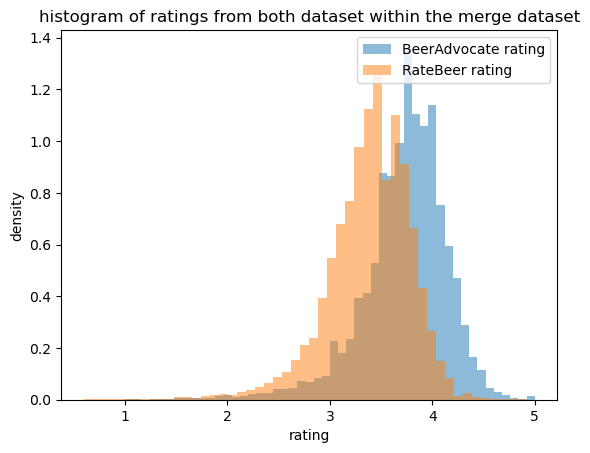

In [40]:
# TODO: warning when comparing ratings between RB and BA: Appearance, Aroma, Palate, Taste and overall have different ranges in both datasets (rating to be double checked)
# for the average rating comparison:
plt.hist(df_beers["avg_computed_ba"], bins=50, alpha=0.5, label='BeerAdvocate rating', density = True)
plt.hist(df_beers["avg_computed_rb"], bins=50, alpha=0.5, label='RateBeer rating', density = True)
plt.title("histogram of ratings from both dataset within the merge dataset")
plt.legend(loc='upper right')
plt.xlabel("rating")
plt.ylabel("density")
plt.show()
#We notice that rate beer is more critical on average that beer advocate. Caution should be taken if two datasets


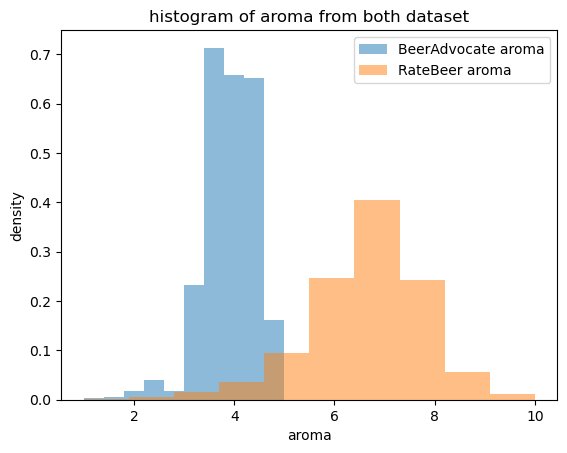

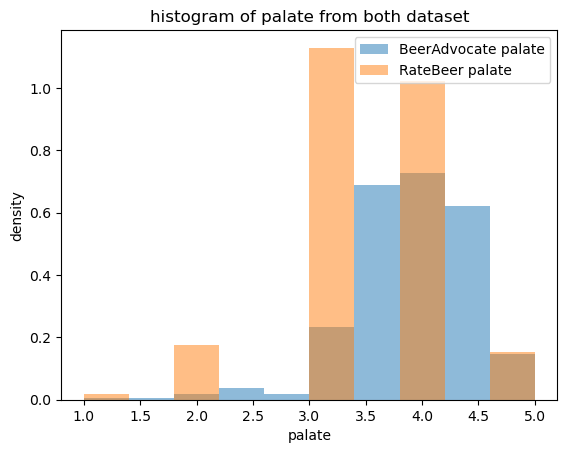

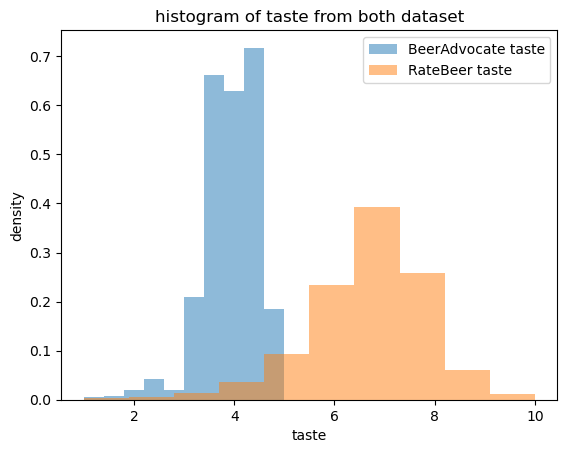

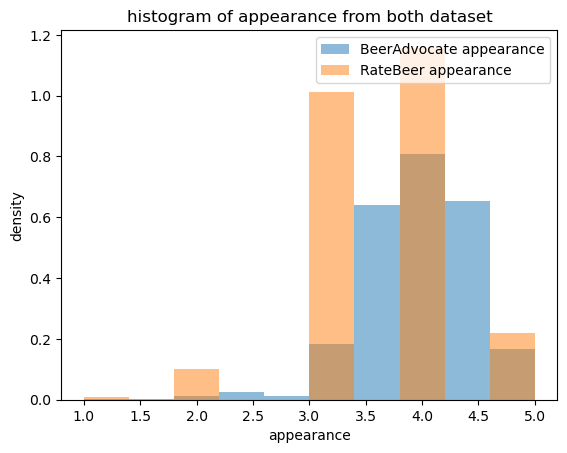

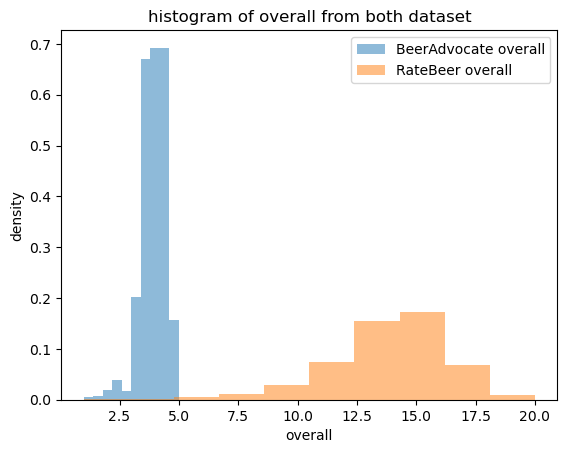

In [41]:
for trait in ["aroma", "palate", "taste", "appearance", "overall"]:
    plt.hist(df_ba[trait], bins=10, alpha=0.5, label=f'BeerAdvocate {trait}', density = True)
    plt.hist(df_rb[trait], bins=10, alpha=0.5, label=f'RateBeer {trait}', density = True)
    plt.title(f"histogram of {trait} from both dataset")
    plt.legend(loc='upper right')
    plt.xlabel(f"{trait}")
    plt.ylabel("density")
    plt.show()


 We see from the previous cell that the scales are very different for the BA and RB, since they use very different schemes to quantify beer quality.
 Apply minmax scaling so the scales are comparable.
 We see that RB and BA has very different distributions since for RB the data can only take integer values whilst for BA it can be a float.

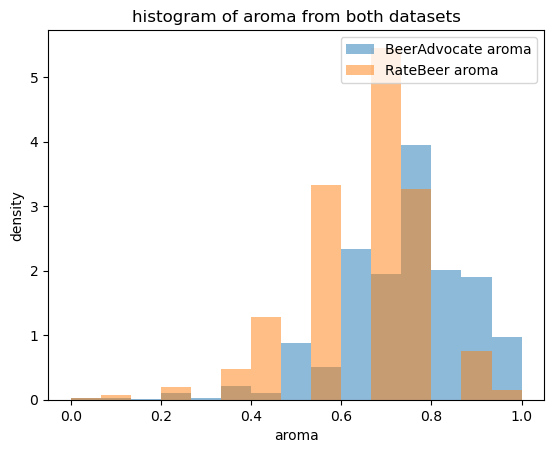

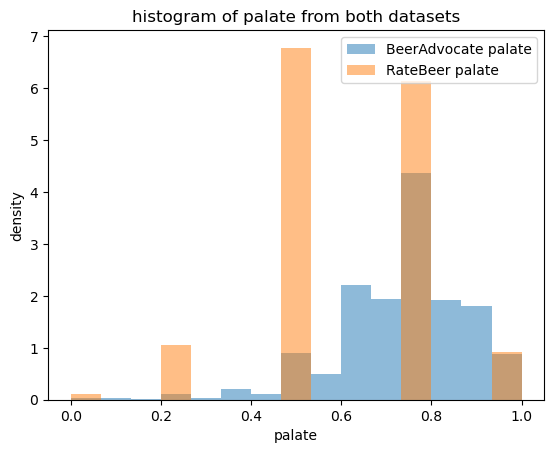

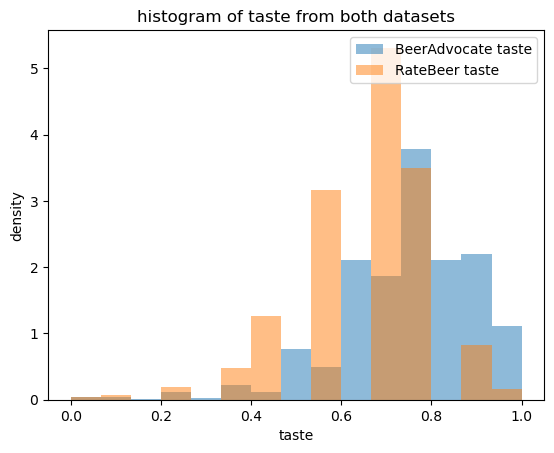

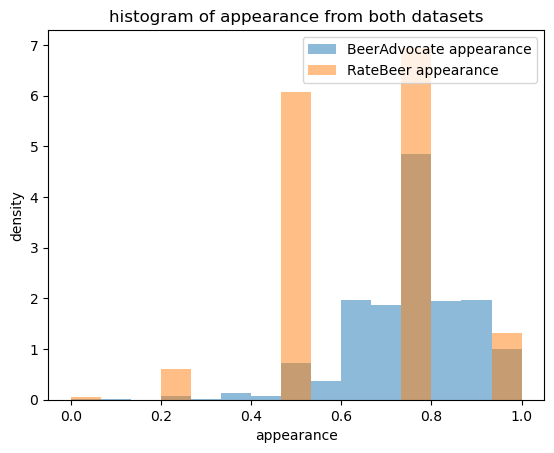

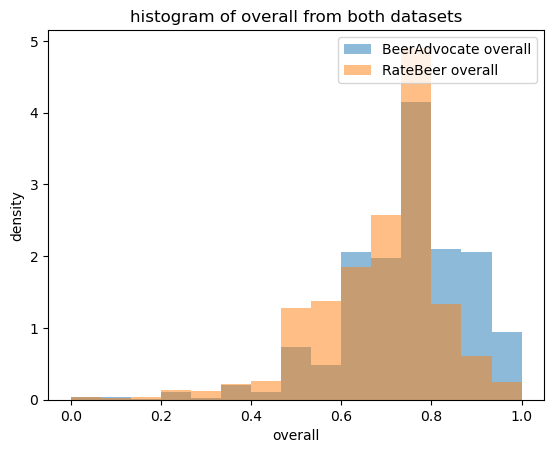

In [42]:
for trait in ["aroma", "palate", "taste", "appearance", "overall"]:
    plt.hist((df_ba[trait]-df_ba[trait].min())/(df_ba[trait].max()-df_ba[trait].min()), bins=15, alpha=0.5, label=f'BeerAdvocate {trait}', density = True)
    plt.hist((df_rb[trait]-df_rb[trait].min())/(df_rb[trait].max()-df_rb[trait].min()), bins=15, alpha=0.5, label=f'RateBeer {trait}', density = True)
    plt.title(f"histogram of {trait} from both datasets")
    plt.legend(loc='upper right')
    plt.xlabel(f"{trait}")
    plt.ylabel("density")
    plt.show()


 We see that the review distibution is heavy tailed, showing that there exist some reviews that are extremely long in comparison to the average reviews.
 This occurs both for the number of words and the number of characters.

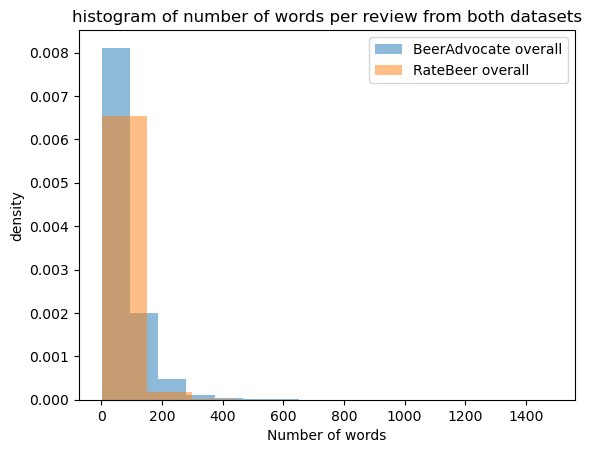

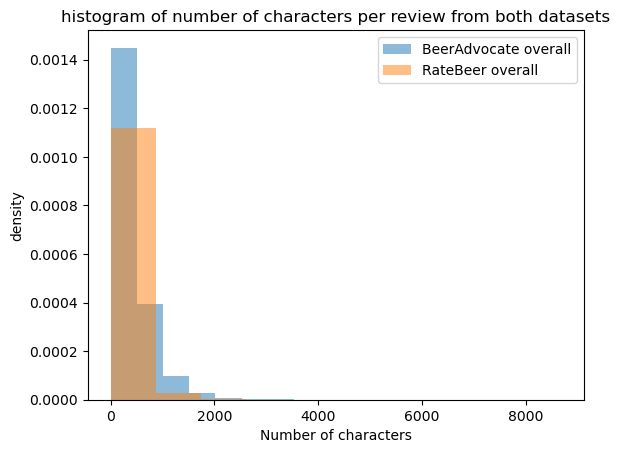

In [43]:
plt.hist(df_ba['text'].str.split(' ').str.len(), bins=10, alpha=0.5, label=f'BeerAdvocate {trait}', density = True)
plt.hist(df_rb['text'].str.split(' ').str.len(), bins=10, alpha=0.5, label=f'RateBeer {trait}', density = True)
plt.title(f"histogram of number of words per review from both datasets")
plt.legend(loc='upper right')
plt.xlabel("Number of words")
plt.ylabel("density")
plt.show()

plt.hist(df_ba['text'].str.len(), bins=10, alpha=0.5, label=f'BeerAdvocate {trait}', density = True)
plt.hist(df_rb['text'].str.len(), bins=10, alpha=0.5, label=f'RateBeer {trait}', density = True)
plt.title(f"histogram of number of characters per review from both datasets")
plt.legend(loc='upper right')
plt.xlabel("Number of characters")
plt.ylabel("density")
plt.show()


 ### map visualization:
load world maps (from [open data soft](https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/)) and us maps from [geopandas default library](https://geopandas.org/en/stable/docs/user_guide/io.html).

In [44]:
url_world_map = "https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/download/?format=shp&timezone=Europe/Berlin&lang=fr"
world = gpd.read_file(url_world_map)
usa = gpd.read_file(gplt.datasets.get_path("contiguous_usa")) #loading usa map from geopandas default library

# need to create per country stats:

country_code
AGO        1
ALB        1
ARG       16
AUS      593
AUT      124
       ...  
URY        1
USA    25645
VNM        8
VUT        2
ZAF       30
Name: country_code, Length: 106, dtype: int64

/Users/kasimirtanner/opt/anaconda3/lib/python3.9/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


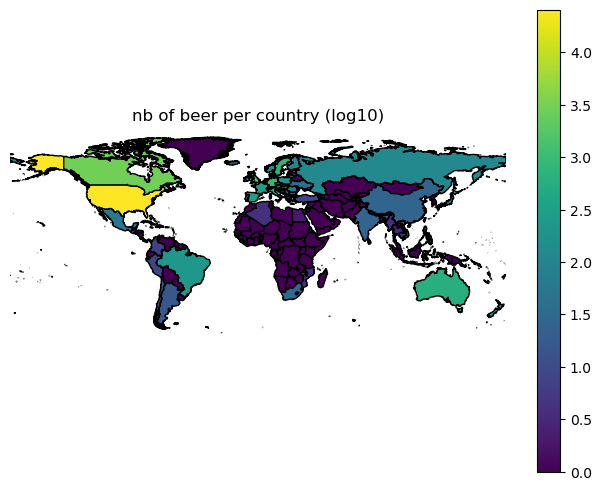

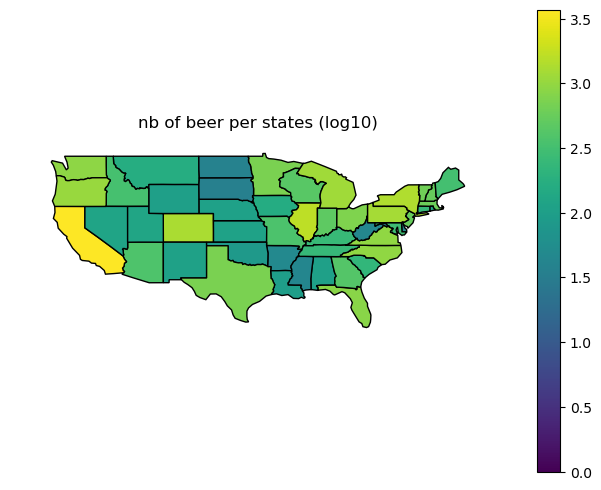

In [45]:
# beer count per country
beer_country = df_beers["country_code"].groupby(df_beers["country_code"]).count()
display(beer_country)
# beer count per state
beer_usa = df_beers.dropna() #countries outside of us have NaN values for the state
beer_states = beer_usa["states"].groupby(beer_usa["states"]).count()

# plotting log number of beers per country
beer_country = world.merge(beer_country, how = "left", left_on="iso3", right_index = True, )
beer_country['log_beers'] = beer_country['country_code'].apply(lambda x: np.log10(x) if x >= 1 else 0)
#number of breweries per country (log)
#scheme = mc.FisherJenks(beer_country['log_beers'], k=8)
gplt.choropleth(beer_country, hue="log_beers", legend=True)
plt.title("nb of beer per country (log10)")
plt.show()

# plotting log number of beers per states
beer_states = usa.merge(beer_states, how = "left", left_on="state", right_index = True)
beer_states['log_beers'] = beer_states['states'].apply(lambda x: np.log10(x) if x >= 1 else 0)

gplt.choropleth(beer_states, hue="log_beers", legend=True)
plt.title("nb of beer per states (log10)")
plt.show()


We can see that most of our data is concentrated in the USA and the North Americas in general. Thus, we make an extra effort to also include US states.

 ## Data enrichment
 ### style clustering
 We want to create better style groupings in order to understand our data better.

In [46]:
style_lookup = dict([
    # taken from: https://www.beeradvocate.com/beer/styles/
    ('Bocks', ['Bock', 'Doppelbock', 'Eisbock', 'Mailbock', 'Weizenbock', 'Maibock / Helles Bock']),
    ('Brown Ales', ['Altbier', 'American Brown Ale', 'Belgian Dark Ale', 'English Brown Ale', 'English Dark Mild Ale']),
    ('Dark Ales', ['Belgian Strong Dark Ale','Dubbel', 'Roggenbier', 'Scottish Ale', 'Winter Warmer']),
    ('Dark Lagers', ['American Amber / Red Lager', 'Czech Amber Lawger','Czech Dark Lager', 'Munich Helles Lager', 'European Dark Lager', 'Märzen','Munich Dunkel', 'Munich Dunkel Lager', 'Rauchbier', 'Schwarzbier', 'Vienna Lager', 'Euro Dark Lager', 'Märzen / Oktoberfest', 'Rauchbier']),
    ('Hybrid Beers', ['Bière de Champagne / Bière Brut', 'Braggot', 'California Common / Steam Beer', 'Cream Ale']),
    ('India Pale Ales', ['English India Pale Ale (IPA)', 'American IPA', 'Belgian IPA', 'Black IPA', 'Brut IPA', 'English IPA', 'Imperial IPA', 'Milkshake IPA', 'New England IPA', 'American Double / Imperial IPA', 'American Black Ale']),
    ('Pale Ales', ['Belgian Strong Pale Ale', 'American Amber / Red Ale', 'Saison / Farmhouse Ale', 'American Blonde Ale', 'American Pale Ale','American Pale Ale (APA)', 'Belgian Blonde Ale', 'Belgian Pale Ale', 'Bière de Garde', 'English Bitter', 'English Pale Ale', 'English Pale Mild Ale', 'Extra Special / Strong Bitter (ESB)', 'Grisette', 'Irish Red Ale', 'Kölsch', 'Saison', 'American Pale Wheat Ale']),
    ('Pale Lagers', ['American Pale Lager', 'Euro Pale Lager', 'American Double / Imperial Pilsner', 'American Adjunct Lager', 'American Lager', 'Bohemian / Czech Pilsner', 'Czech Pale Lager', 'European / Dortmunder Export Lager', 'European Pale Lager', 'European Strong Lager', 'Festbier / Wiesnbier', 'German Pilsner', 'German Pilsener', 'Czech Pilsener', 'Helles', 'Imperial Pilsner', 'India Pale Lager (IPL)', 'Kellerbier / Zwickelbier', 'Light Lager', 'Malt Liquor', 'American Malt Liquor', 'Dortmunder / Export Lager', 'Euro Strong Lager']),
    ('Porters', ['American Porter', 'Baltic Porter', 'English Porter', 'Imperial Porter', 'Robust Porter', 'Smoked Porter']),
    ('Speciality Beers', ['Chile Beer', 'Fruit and Field Beer', 'Gruit / Ancient Herbed Ale', 'Happoshu', 'Herb and Spice Beer', 'Japanese Rice Lager', 'Kvass', 'Low-Alcohol Beer', 'Pumpkin Beer', 'Rye Beer', 'Sahti', 'Smoked Beer']),
    ('Stouts', ['American Imperial Stout', 'American Stout', 'English Stout', 'Foreign / Export Stout', 'Irish Dry Stout', 'Oatmeal Stout', 'Russian Imperial Stout', 'Sweet / Milk Stout', 'Milk / Sweet Stout', 'American Double / Imperial Stout', 'Black & Tan']),
    ('Strong Ales', ['American Barleywine', 'American Strong Ale', 'Belgian Dark Strong Ale', 'Belgian Pale Strong Ale', 'English Barleywine', 'English Strong Ale', 'Imperial Red Ale', 'Old Ale', 'Quadrupel (Quad)', 'Scotch Ale / Wee Heavy', 'Tripel', 'Wheatwine']),
    ('Wheat Beers', ['American Dark Wheat Beer', 'American Pale Wheat Beer', 'Dunkelweizen', 'Grodziskie', 'Hefeweizen', 'Kristallweizen', 'Witbier', 'American Dark Wheat Ale', 'Kristalweizen']),
    ('Wild/Sour Beers', ['Berliner Weisse', 'Berliner Weissbier', 'Brett Beer', 'Faro', 'Flanders Oud Bruin', 'Flanders Red Ale', 'Fruit Lambic', 'Fruited Kettle Sour', 'Gose', 'Gueuze', 'Lambic', 'Wild Ale', 'American Wild Ale', 'Lambic - Unblended']),
    ('Other', ['Fruit / Vegetable Beer', 'Low Alcohol Beer', 'Scottish Gruit / Ancient Herbed Ale', 'Lambic - Fruit', 'Herbed / Spiced Beer', 'Pumpkin Ale'])
])

df_beers['style_class'] = 'UNASSIGNED'

for style_keys in style_lookup.keys():
    df_beers['style_class'] = np.where(df_beers['style_ba'].isin(style_lookup[style_keys]), style_keys, df_beers['style_class'])


print(df_beers['style_class'].value_counts(sort=True))


Pale Ales           10613
India Pale Ales      7782
Stouts               3279
Wild/Sour Beers      2447
Pale Lagers          1946
                    ...  
Dark Lagers          1285
Dark Ales            1024
Bocks                 705
Speciality Beers      587
Hybrid Beers          395
Name: style_class, Length: 15, dtype: int64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


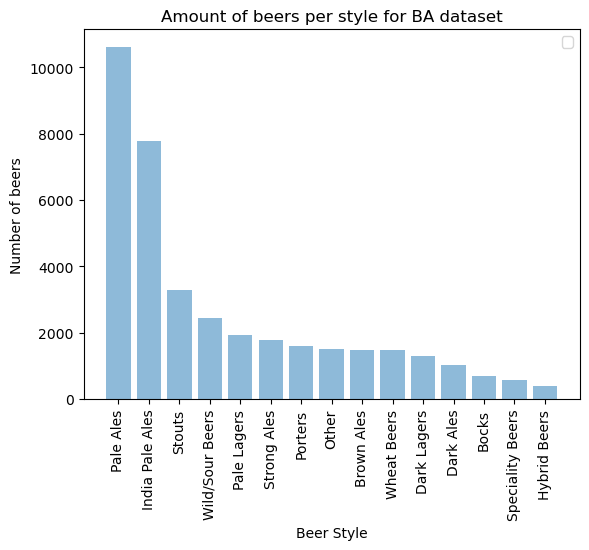

In [47]:
counts = df_beers["style_class"].value_counts().sort_values(ascending=False)
names = counts.index
plt.bar(names, counts, alpha=0.5)
# plt.hist(df_ba_beers["style_class"], )
plt.title(f"Amount of beers per style for BA dataset")
plt.legend(loc='upper right')
plt.xlabel("Beer Style")
plt.ylabel("Number of beers")
plt.xticks(rotation=90)
plt.show()


The predominant beer styles are Pale Ales and Indian Pale Ales. In total we have 15 classes of beer styles.

 # Plan for Investigation/Methods:
 ### RQ1: Are beer preferences influenced by geography/culture?
 We investigate this by figuring out preferred beer styles.
 We can conduct t-tests to see if there is a significant difference in ratings per beer style between countries, using the Sidak correction.
 ### RQ2: Do different cultures prioritise/prefer different aspects of beers such as feel? Are some cultures more critical of beer?
 We can conduct the exact same analysis as in RQ1 for each of the beer characteristics (palate, etc.) and also for beer ratings in general.
 ### RQ3: Do different cultures have stylistically different ways of writing reviews and discussing beer? Do users talk about foreign beers differently than they talk about their local ones?
 Reviews for each country will just be aggregated into a large piece of text since we strictly interested in comparing per country. We focus on English speaking countries.
 To do textual analysis, we will first conduct textual preprocessing steps. This will involving removing punctuation, removing stopwords, capitalisation and most importantly choosing indexing terms. Depending on results, we may find that other steps should also be taken.
 After this preprocessing, we will vectorise the corpus. To do this, we can use a count vectoriser (bag of words model), tf-idf or other methods. Finally, we will compute distances between textual reviews by choosing either existing research methods e.g. [Ruzicka](https://github.com/mikekestemont/ruzicka), [PyStyl](https://github.com/mikekestemont/pystyl), or by using cosine distance metric.

 Depending on the results of this, we can then investigate if the distances between the corpuses can represent the cultural similarity between countries.
 If so, it may be interesting to run a dendrogram clustering using [sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html) to see if we can recreate geographical regions.
 It may be that we can recreate a North American group, Oceanic group and European group. This will obviously depend on our results.

 Furthermore, we will also create a wordmap of the language used in reviews. Either we can use simple frequency analysis, or again we can leverage existing libraries such as [word-cloud](https://github.com/amueller/word_cloud).

 We can also rerun our distance analysis for each country between reviews for local and foreign beer to see if there is a difference. We can then see what countries exhibit this difference the most.

### RQ4: Is there a "home bias" for reviewers?
I.e. do users rate local beers higher than their foreign counterparts?
The hypothesis is the following:
$H_0$: $\mu_l = \mu_f$
$H_a$: $\mu_l \neq \mu_f$

where $\mu_l$ ($\mu_f$) is the average user ratings given to local (foreign) beers.

We have to control the effect of confounders. Here the "treatment" might be identified as "do the users and the beers come from the same country". 
We call an experiment treated (treatment=1), if the user and the beer come from the same country. On the otherhand, if the user and the beer do not come from the same country, we set treatment = 0.
However, there are some covariates (such as users' taste, whether they are overall more critical or not, etc...). These might influence both the outcome (the users' rating of that beer) and the likelihood to be from the same place as the beer. To mitigate this effect, we match users based on propensity. A propensity score measures the probability of a user to rate beer from his own country/state (treatment = 1) vs. a foreign beer (treatment = 0) given observed covariates. Is is learned using logistic regression with labels being 1 if the reviewed beer is local, 0 if it is foreign. Some features considered are for example users' average ratings, number of ratings, users' "taste" (ratings per style), country, etc...


 # Plan for Communication/Visualisation:
 We plan to tell the following story (_obviously result dependent_):
 1. [HeatMap] Show that there are differences in ratings and beer preferences using our initial analyses.
 2. [HeatMap, WordCloud] Show that there are differences in how different countries talk about beers.
 3. [Dendrogram] Try and relate this to cultural or geographical proximities of the countries.
 3. [HeatMap] See if there is a difference for each country in how they talk about local and foreign beers.
 4. [HeatMap] Show the results for our detailed analysis into home bias to determine if users have a preference for local produce or not.
 5. Give our main takeaways.